# Ordinary Least-Squares Fitting Code Implementing the Levenberg-Marquardt (LM) algorithm

## Step 1: Import packages

In [1]:
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

## Step 2: The LM algorithm for a Gaussian model

The Gaussian probability distribution function I use here takes the form: 
$$ \phi(\nu) = \frac{1}{\alpha_D} \sqrt{\frac{\ln 2}{\pi}} \exp \left(\frac{-(\ln 2)(\nu - \nu_0)^2}{\alpha_D{^2}}\right) $$

In [2]:
# the Gaussian model
def gaussian(x, v0, alpha_D):
    return (1/alpha_D) * np.sqrt(np.log(2)/np.pi) * np.exp((-np.log(2)*(x - v0)**2)/(alpha_D**2))

# the Gaussian model residuals
def residuals_gaussian(params, x, y):
    v0, alpha_D = params
    return gaussian(x, v0, alpha_D) - y

# the Jacobian matrix for the Gaussian model
def jacobian_gaussian(params, x, y):
    v0, alpha_D = params
    J = np.zeros((len(x), 2))
    J[:, 0] = ((2*(np.log(2)**(3/2))*(x - v0))/((alpha_D**3)*np.sqrt(np.pi)))*np.exp((-np.log(2)*(x - v0)**2)/(alpha_D**2))                    # dG/dv0
    J[:, 1] = (1/(alpha_D**4))*np.sqrt(np.log(2)/np.pi)*np.exp((-np.log(2)*(x - v0)**2)/(alpha_D**2))*(2*np.log(2.)*(x - v0)**2 - alpha_D**2.) # dG/dalpha_D
    return J

# the LM update step
def update_params(params, x, y, J, lambda_, r):
    delta = np.linalg.solve(J.T.dot(J) + lambda_ * np.diag(np.diag(J.T.dot(J))), -J.T.dot(r))
    params_new = params + delta
    return params_new

# the fitting function
def levmar_gaussian(params, x, y, max_iter=100, tol=1e-6):
    # the main LM loop
    for i in range(max_iter):
        r = residuals_gaussian(params, x, y)
        J = jacobian_gaussian(params, x, y)
        if np.linalg.norm(r) < tol:
            break
        lambda_ = 0.001
        params_new = update_params(params, x, y, J, lambda_, r)
        r_new = residuals_gaussian(params_new, x, y)
        while np.dot(r_new, r_new) > np.dot(r, r) and lambda_ < 1e20: 
            lambda_ *= 10
            params_new = update_params(params, x, y, J, lambda_, r)
            r_new = residuals_gaussian(params_new, x, y)
        params = params_new
        lambda_ /= 10
        
    # uncertainty estimation   
    r = residuals_gaussian(params, x, y)
    J = jacobian_gaussian(params, x, y)

    N = len(y)
    p = len(params)

    sigma2 = np.dot(r, r) / (N - p)
    cov = sigma2 * np.linalg.inv(J.T @ J)
    errors = np.sqrt(np.diag(cov))
    
    return params, errors, cov

## Step 3: The LM algorithm for a Lorentzian (Cauchy) model
The Lorentzian probability distribution function I use here takes the form: 
$$ \phi(\nu) = \frac{1}{\pi} \frac{\alpha_L}{(\nu - \nu_0)^2 + \alpha_L{^2}} $$

In [3]:
# the Lorentzian model
def lorentzian(x, v0, alpha_L):
    return (1/np.pi)*(alpha_L/((x - v0)**2 + alpha_L**2))

# the Lorentzian model residuals
def residuals_lorentzian(params, x, y):
    v0, alpha_L = params
    return lorentzian(x, v0, alpha_L) - y

# the Jacobian matrix for Lorentzian model
def jacobian_lorentzian(params, x, y):
    v0, alpha_L = params
    J = np.zeros((len(x), 2))
    J[:, 0] = (2.*(x - v0)*alpha_L)/(np.pi*((x - v0)**2. + alpha_L**2.)**2.)               # dL/dv0
    J[:, 1] = (1./np.pi)*(((x - v0)**2. - alpha_L**2.)/(((x - v0)**2. + alpha_L**2.)**2.)) # dL/dalpha_L
    return J

# the fitting function
def levmar_lorentzian(params, x, y, max_iter=100, tol=1e-6):
    # the main LM loop
    for i in range(max_iter):
        r = residuals_lorentzian(params, x, y)
        J = jacobian_lorentzian(params, x, y)
        if np.linalg.norm(r) < tol:
            break
        lambda_ = 0.001
        params_new = update_params(params, x, y, J, lambda_, r)
        r_new = residuals_lorentzian(params_new, x, y)
        while np.dot(r_new, r_new) > np.dot(r, r) and lambda_ < 1e20:
            lambda_ *= 10
            params_new = update_params(params, x, y, J, lambda_, r)
            r_new = residuals_lorentzian(params_new, x, y)
        params = params_new
        lambda_ /= 10

    # uncertainty estimation
    r = residuals_lorentzian(params, x, y)
    J = jacobian_lorentzian(params, x, y)

    N = len(y)
    p = len(params)

    sigma2 = np.dot(r, r) / (N - p)
    cov = sigma2 * np.linalg.inv(J.T @ J)
    errors = np.sqrt(np.diag(cov))
    
    return params, errors, cov

## Step 4: Read in the data

In [4]:
data = ascii.read('lm_data.dat')

## Step 5: Show the results for each of the models

### Step 5.1: Lorentzian results

Best-fit parameters:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

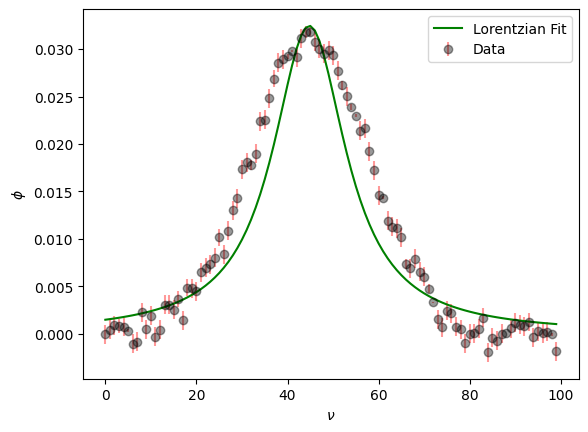

In [5]:
# fit the model to the data
params = np.array([45.0, 10.0]) # Initial guesses
params_fit, errors, cov = levmar_lorentzian(params, data['col1'], data['col2'])

print("Best-fit parameters:")
labels = [r"\nu_0", r"\alpha_L"]
for i in range(len(labels)):
    median, lower, upper = params_fit[i], errors[i], errors[i]
    txt = r"\mathrm{{{0}}} = {1:.3f}_{{-{2:.3f}}}^{{+{3:.3f}}}".format(labels[i], median, lower, upper)
    display(Math(txt))
    
# plot
fig = plt.figure()
plt.errorbar(data['col1'], data['col2'], yerr=data['col3'], fmt='o', 
             alpha=0.4, color='black', ecolor='red', label='Data')
plt.plot(data['col1'], lorentzian(data['col1'], *params_fit), color='green', label='Lorentzian Fit')

plt.xlabel(r'$\nu$')
plt.ylabel(r'$\phi$')
plt.legend()
plt.show()

### Step 5.2: Gaussian results

Best-fit parameters:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

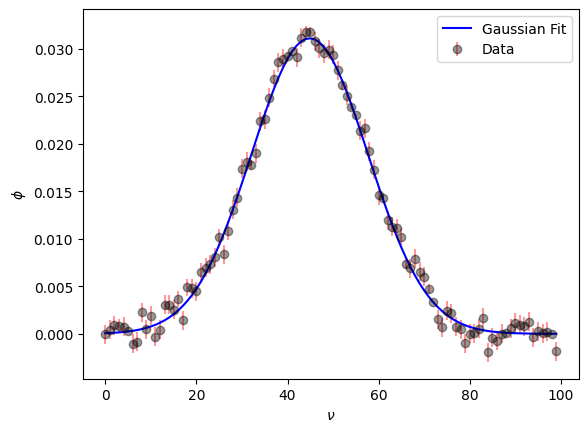

In [6]:
# fit the model to the data
params = np.array([45.0, 10.0]) # Initial guesses
params_fit, errors, cov = levmar_gaussian(params, data['col1'], data['col2'])

print("Best-fit parameters:")
labels = [r"\nu_0", r"\alpha_D"]
for i in range(len(labels)):
    median, lower, upper = params_fit[i], errors[i], errors[i]
    txt = r"\mathrm{{{0}}} = {1:.3f}_{{-{2:.3f}}}^{{+{3:.3f}}}".format(labels[i], median, lower, upper)
    display(Math(txt))
    
# plot
fig = plt.figure()
plt.errorbar(data['col1'], data['col2'], yerr=data['col3'], fmt='o', 
             alpha=0.4, color='black', ecolor='red', label='Data')
plt.plot(data['col1'], gaussian(data['col1'], *params_fit), color='blue', label='Gaussian Fit')

plt.xlabel(r'$\nu$')
plt.ylabel(r'$\phi$')
plt.legend()
plt.show()